In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load(file):
    lines = open(file, "r").readlines()

    for i, line in enumerate(lines):
        # Find root
        if line.startswith('; |'):
            root_line = i
        if line.startswith('Note: For table entries with two numbers listed,'):
            last_line = i - 2

    del lines[last_line+1:]

    # Extract header:
    header = list(filter(None,[x.strip() for x in lines[root_line - 2].split(';')]))

    # Extract data:
    del lines[0:root_line]

    raw_data = []

    for line in lines:
        row = list(filter(None, [x.strip() for x in line.split(';')]))
        # The utilization number between () is resource utilization in the unit itself, without its children.
        # Remove utilization of entity itself:
        row = [x.split('(')[0] for x in row]
        raw_data.append(row)

    df = pd.DataFrame(data=raw_data, columns=header)
    
    df['ALMs'] = pd.to_numeric(df['ALMs needed [=A-B+C]'])
    df['Regs'] = pd.to_numeric(df['Dedicated Logic Registers'])
    df['M20Ks'] = pd.to_numeric(df['M20Ks'])
    df['DSP'] = pd.to_numeric(df['DSP Blocks'])
    
    return df[['Entity Name', 'Full Hierarchy Name', 'ALMs', 'Regs', 'M20Ks', 'DSP']]

In [3]:
device = {
    'Device' : 'Arria 10 GX 1150',
    'LE' : 1150 * 1e3,
    'ALM' : 427200,
    'Register' : 1708800,
    'Memory M20k' : 54260,
    'Memory MLAB' : 12984,
    'Variable-precision DSP Block': 1518,
    '18x19 Multiplier' : 3036,
}

reports_bs = [
    (1, '/home/johan/Desktop/jsonpaper/builds/battery/1/synth/afu_default-Resource-Utilization-by-Entity.rpt'),
    (2, '/home/johan/Desktop/jsonpaper/builds/battery/2/synth/afu_default-Resource-Utilization-by-Entity.rpt'),
    (4, '/home/johan/Desktop/jsonpaper/builds/battery/4/synth/afu_default-Resource-Utilization-by-Entity.rpt'),
    (8, '/home/johan/Desktop/jsonpaper/builds/battery/8/synth/afu_default-Resource-Utilization-by-Entity.rpt'),
    (16, '/home/johan/Desktop/jsonpaper/builds/battery/16/synth/afu_default-Resource-Utilization-by-Entity.rpt')
]

reports_tr = [
    (1, '/home/johan/Desktop/jsonpaper/builds/trip/1/synth/afu_default-Resource-Utilization-by-Entity.rpt'),
    (2, '/home/johan/Desktop/jsonpaper/builds/trip/2/synth/afu_default-Resource-Utilization-by-Entity.rpt'),
    (3, '/home/johan/Desktop/jsonpaper/builds/trip/3/synth/afu_default-Resource-Utilization-by-Entity.rpt')
]

reports = reports_tr

# entities of interest
eoi = ['dcp_top', 'OpaeAxiTop', 'battery_status', 'BattSchemaParser', 'ArrayReader', 'ArrayWriter']
eoi = ['dcp_top', 'OpaeAxiTop', 'TripReportParser', 'trip_report', 'ArrayReader', 'ArrayWriter', 'PacketArbiter', 'trip_report_output']
#df = df[df['Entity Name'].isin(eoi)]

records = []
for report in reports:
    # Load file
    df = load(report[1])
    # Set number of kernels
    df['Kernels'] = report[0]
    #records.append(df.loc['|'])
    records.append(df[df['Entity Name'].isin(eoi)])
    

df = pd.concat(records)

df = df.groupby(['Kernels', 'Entity Name']).aggregate('sum')

df['ALMs %'] = df.ALMs / device['ALM'] * 100
df['Regs %'] = df.Regs / device['Register']  * 100
df['M20Ks %'] = df.M20Ks / device['Memory M20k']  * 100
df['DSP %'] = df.DSP / device['18x19 Multiplier']   * 100

display(df)

ALMs    Regs  M20Ks  DSP     ALMs %  \
Kernels Entity Name                                                   
1       ArrayReader           4173.0    8169     26    0   0.976826   
        ArrayWriter          67271.9  208124    567    0  15.747168   
        OpaeAxiTop          142835.8  302689    705    0  33.435346   
        PacketArbiter          166.5     183      0    0   0.038975   
        TripReportParser     54138.8   48505     87    0  12.672940   
        dcp_top             179625.0  355440    871    0  42.047051   
        trip_report          57393.4   56784    108    0  13.434785   
        trip_report_output   67272.2  208124    567    0  15.747238   
2       ArrayReader           7967.4   16285     52    0   1.865028   
        ArrayWriter          60367.3  208153    567    0  14.130922   
        OpaeAxiTop          193240.7  366136    839    0  45.234246   
        PacketArbiter          251.9     252      0    0   0.058965   
        TripReportParser    106126.3   96714    174    0  24.842299   
        dcp_top             229456.4  418888   1005    0  53.711704   
        trip_report         111357.6  110710    216    0  26.066854   
        trip_report_output   60367.3  208153    567    0  14.130922   
3       ArrayReader          11897.8   24432     78    0   2.785066   
        ArrayWriter          60089.9  208089    567    0  14.065988   
        OpaeAxiTop          253114.0  429334    973    0  59.249532   
        PacketArbiter          340.5     278      0    0   0.079705   
        TripReportParser    159231.9  144765    261    0  37.273385   
        dcp_top             289275.2  482044   1139    0  67.714232   
        trip_report         167244.6  164466    324    0  39.149017   
        trip_report_output   60089.7  208089    567    0  14.065941   

                               Regs %   M20Ks %  DSP %  
Kernels Entity Name                                     
1       ArrayReader          0.478055  0.047917    0.0  
        ArrayWriter         12.179541  1.044969    0.0  
        OpaeAxiTop          17.713542  1.299300    0.0  
        PacketArbiter        0.010709  0.000000    0.0  
        TripReportParser     2.838542  0.160339    0.0  
        dcp_top             20.800562  1.605234    0.0  
        trip_report          3.323034  0.199042    0.0  
        trip_report_output  12.179541  1.044969    0.0  
2       ArrayReader          0.953008  0.095835    0.0  
        ArrayWriter         12.181238  1.044969    0.0  
        OpaeAxiTop          21.426498  1.546259    0.0  
        PacketArbiter        0.014747  0.000000    0.0  
        TripReportParser     5.659761  0.320678    0.0  
        dcp_top             24.513577  1.852193    0.0  
        trip_report          6.478816  0.398083    0.0  
        trip_report_output  12.181238  1.044969    0.0  
3       ArrayReader          1.429775  0.143752    0.0  
        ArrayWriter         12.177493  1.044969    0.0  
        OpaeAxiTop          25.124883  1.793218    0.0  
        PacketArbiter        0.016269  0.000000    0.0  
        TripReportParser     8.471735  0.481017    0.0  
        dcp_top             28.209504  2.099152    0.0  
        trip_report          9.624649  0.597125    0.0  
        trip_report_output  12.177493  1.044969    0.0

Index(['ArrayReader', 'ArrayWriter', 'OpaeAxiTop', 'PacketArbiter',
       'TripReportParser', 'dcp_top', 'trip_report', 'trip_report_output'],
      dtype='object', name='Entity Name')

Int64Index([1, 2, 3], dtype='int64', name='Kernels')

['ALMs %', 'Regs %', 'M20Ks %']

[(0.11379369138959927, 0.2300085251491899, 0.44306905370843996),
 (0.19575099942889762, 0.5323053493241956, 0.1751456310679611),
 (0.5881182323675741, 0.15070529704419078, 0.15070529704419078),
 (0.6132848190822722, 0.5083808368708307, 0.1694602789569435),
 (0.7637589670014348, 0.20722142515542796, 0.5979818268770923),
 (0.03843137254901963, 0.026627450980392167, 0.016470588235294126)]

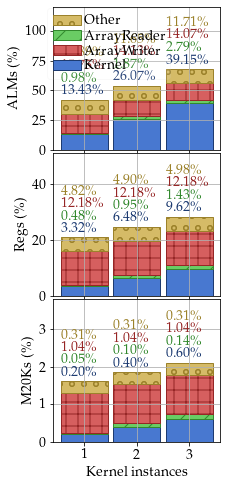

In [17]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

ress = ['ALMs %', 'Regs %', 'M20Ks %'] #, 'DSP %'] , designs dont use dsp

doi = df[ress]

ents = doi.index.unique(1)
kers = doi.index.unique(0)

display(ents)
display(kers)
display(ress)

fig, ax = plt.subplots(nrows=len(ress), ncols=1, figsize=[3, 8])

hatches = [None, '/', '+', 'o']
colors = ['#4878d0', '#6acc64', '#d65f5f', '#d5bb67', '#dc7ec0', '#8c613c']
dcolors = [lighten_color(x, 1.6) for x in colors]
display(dcolors)

ymaxes = [doi[x].max()*1.2 for x in ress]

ax[len(ress)-1].set_xlabel('Kernel instances')

w=0.9
ap = {'arrowstyle' : '->'}
lf = '{:2.2f}\%'
ls = '-'
lw = 1

for r,res in enumerate(ress):
    yl = ress[r].replace('%', '(\%)')
    ax[r].set_ylabel(yl)
        
    for c, knl in enumerate(kers):
        ax[r].set_ylim(0, min(120, 1.5*ymaxes[r]))
        ax[r].set_xticks(range(0, len(kers)))
        ax[r].set_xticklabels(kers)
        ax[r].grid(which='both')
        
        ab = doi.loc[knl,'trip_report'][res]
        ar = doi.loc[knl,'ArrayReader'][res]
        aw = doi.loc[knl,'ArrayWriter'][res]
        ao = doi.loc[knl,'dcp_top'][res] - ar - aw - ab
        
        bottoms = [0, ab, ab+ar, ab+ar+aw, ab+ar+aw+ao]
        
        bb = ax[r].bar(x=c, height=ab, width=w, bottom=bottoms[0], color=colors[0], ec=dcolors[0], hatch=hatches[0], ls=ls, lw=lw)
        br = ax[r].bar(x=c, height=ar, width=w, bottom=bottoms[1], color=colors[1], ec=dcolors[1], hatch=hatches[1], ls=ls, lw=lw)
        bw = ax[r].bar(x=c, height=aw, width=w, bottom=bottoms[2], color=colors[2], ec=dcolors[2], hatch=hatches[2], ls=ls, lw=lw)
        bo = ax[r].bar(x=c, height=ao, width=w, bottom=bottoms[3], color=colors[3], ec=dcolors[3], hatch=hatches[3], ls=ls, lw=lw)
        
        ax[r].annotate(text=lf.format(ab), xy=(c-w/2, bottoms[4]+0.05*ymaxes[r]), color=dcolors[0])
        ax[r].annotate(text=lf.format(ar), xy=(c-w/2, bottoms[4]+0.18*ymaxes[r]), color=dcolors[1])
        ax[r].annotate(text=lf.format(aw), xy=(c-w/2, bottoms[4]+0.31*ymaxes[r]), color=dcolors[2])
        ax[r].annotate(text=lf.format(ao), xy=(c-w/2, bottoms[4]+0.44*ymaxes[r]), color=dcolors[3])
        

for r, res in enumerate(ress):
    if r != len(ress)-1:
        ax[r].get_xaxis().set_ticklabels([])


fig.legend([bo, br, bw, bb],
           ['Other', 'ArrayReader', 'ArrayWriter', 'Kernel'],
           ncol=1,
           bbox_to_anchor=[0.7, 0.89],
           labelspacing=0,
           handletextpad=0.25,
           handlelength=2.0,
           columnspacing=0.5,
           frameon=True,
           framealpha=0.1
          )
        
plt.subplots_adjust(hspace=0.025, wspace=0)

fig.savefig('utilization.pdf', bbox_inches='tight')


KeyError: 16

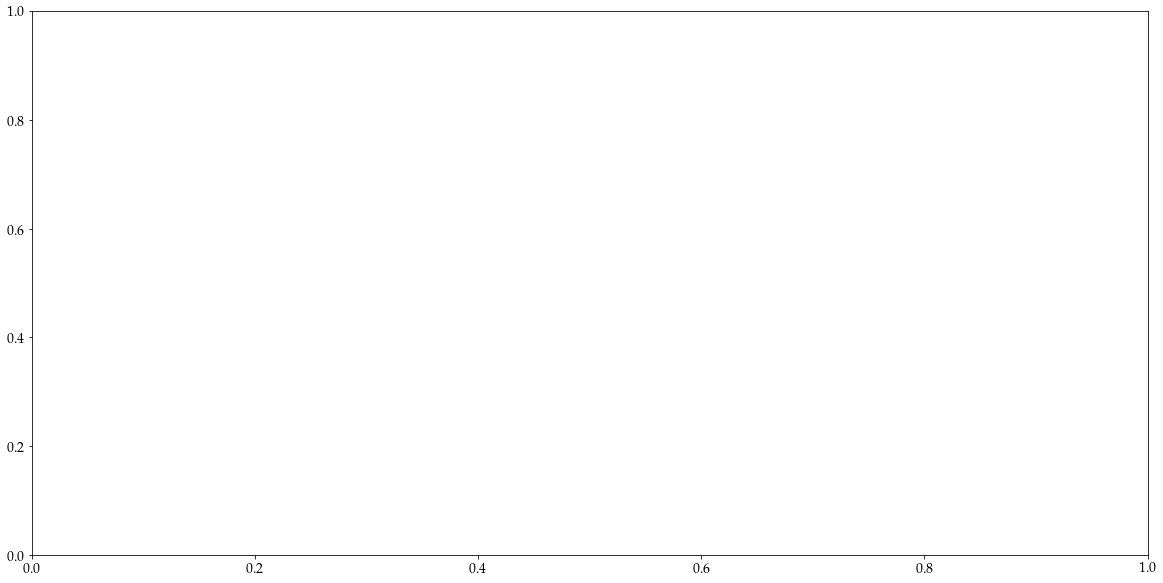

In [6]:
from matplotlib.sankey import Sankey

k = 16

fig, ax = plt.subplots(figsize=[20, 10])

flows_a = [device['ALM'],
          df.loc[k,'dcp_top']['ALMs'] - device['ALM'],
          - df.loc[k,'dcp_top']['ALMs']]
labels_a = ['Available', 'Unused', 'Design']
or_a = [0, 1, 0]

flows_b = [df.loc[k,'dcp_top']['ALMs'],
         df.loc[k,'OpaeAxiTop']['ALMs'] - df.loc[k,'dcp_top']['ALMs'],
         -df.loc[k,'ArrayReader']['ALMs'],
         -df.loc[k,'ArrayWriter']['ALMs'],
         -df.loc[k,'battery_status']['ALMs']]

labels_b = ['', 'Shell', 'ArrayReaders', 'ArrayWriters', 'Kernel']

or_b=[0, 1, 1, 1, 0]

s = Sankey(ax=ax,
           scale=1/df.loc[k,'dcp_top']['ALMs'],
           head_angle=180,
           offset=0.1,
           shoulder=0)

s.add(flows=flows_a, 
      labels=labels_a,
      trunklength=0.1,
      orientations=or_a)

s.add(flows=flows_b, 
      labels=labels_b,
      orientations=or_b,
      prior=0,
      connect=(2,0))

plt.autoscale(ax)

ax.set_yticks([])
ax.set_xticks([])